# Fourth Task: Prediction

### Import of the needed libraries and the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
import pydotplus 
from IPython.display import Image  
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import wittgenstein as lw
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

cyclists = pd.read_csv('./dataset/cyclists_trasformed.csv')
races = pd.read_csv('./dataset/races_trasformed.csv')

# Data Preparation

Before employing the learning algorithms to fit a prediction model for the given purpose (= predict the final position in a race for a given cyclist), we need to perform a few adjustments to our data. 

Firstly, it is necessary to merge the two dataset and delete not useful columns for the purpose.

Then we will add one for specifying if a certain cyclist was in the first 20 position of a race or not. 

We delete:

• *name* (coming from cyclist), since it is a repetition for *_url* in cyclist

• *name* (coming from races), since it is a repetition for *_url* in races

• *weight* and *height* (coming from cyclist), since these characteristics are combined in the *bmi* feature we created 

• *avg_position* and *avg_delta* (coming from cyclist), since it is better to consider more precise columns like *position* (see next) and *delta* from races

• *position* (coming from races) since we consider only the first 20 we will get from the new column 

• *birth_year* (coming from cyclist) because it's redundant having *cyclist_age* from races

• *cyclist_team* (coming from races) since we consider single cyclists

• *date* (coming from races) whose format is: "YYYY-MM-DD HH-MM-SS". From it, we can extract the information we need: we exclude the "HH-MM-SS" and the "MM-DD" part because we can easily group races based on the *season* of the year (attribute that we already have). At the end, we only care about the year for splitting the races for the training set.

We add:

• *top_20*, having value =1 if the corresponding cyclist was in between these positions or, on the opposite, =0.

**NB**: we drop *position* after creating the column *top_20*, since it is needed to fill the new one correctly.

In [2]:
#Merge
data_merged = pd.merge(races, cyclists, left_on='cyclist', right_on='_url', how='outer', indicator=True)

#Filter non-corresponding rows: these cyclists never participate to a competition, so we don't consider them either for the prediction
mismatched = data_merged[data_merged['_merge'] != 'both']
print(f"Number of mismatched entries: {len(mismatched)}")
print(mismatched)

#Drop 
data_merged = data_merged[data_merged['_merge'] == 'both']

#Drop the '_merge' column as it's no longer needed
data_merged.drop('_merge', axis=1, inplace=True)


Number of mismatched entries: 39
       _url_x name_x  points  length  climb_total  profile  startlist_quality  \
53046     NaN    NaN     NaN     NaN          NaN      NaN                NaN   
56942     NaN    NaN     NaN     NaN          NaN      NaN                NaN   
61189     NaN    NaN     NaN     NaN          NaN      NaN                NaN   
89300     NaN    NaN     NaN     NaN          NaN      NaN                NaN   
94337     NaN    NaN     NaN     NaN          NaN      NaN                NaN   
139563    NaN    NaN     NaN     NaN          NaN      NaN                NaN   
142896    NaN    NaN     NaN     NaN          NaN      NaN                NaN   
154121    NaN    NaN     NaN     NaN          NaN      NaN                NaN   
171916    NaN    NaN     NaN     NaN          NaN      NaN                NaN   
180790    NaN    NaN     NaN     NaN          NaN      NaN                NaN   
197846    NaN    NaN     NaN     NaN          NaN      NaN                Na

Following the specification, we create the new attribute *top_20* where the value is '1' if in the row the attribute *position* ranges from 0 to 19, '0' otherwise. 

As stated before, we drop *position* since is useless from now on and modify *date* so that it contains only the year. 


In [3]:
# Rename '_url_x' in 'race_url' and '_url_y' in 'cyclist_url'
data_merged.rename(columns={'_url_x': 'race_url', '_url_y':'cyclist_url'}, inplace=True)

#Delete useless columns we cited, except position
data_merged = data_merged.drop(columns=['name_x', 'name_y', 'cyclist', 'weight', 'height', 'birth_year', 'avg_position', 'avg_delta', 'cyclist_team'])

#Create 'top_20'
data_merged['top_20'] = (data_merged['position'] < 20).astype(int)

#Drop position 
data_merged = data_merged.drop(columns=['position']) 

data_merged.head()

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,tour-de-france/1978/stage-6,100.0,162000.0,1101.0,1.0,1241.0,1978-07-05 04:02:51,27.0,True,27.0,7.0,summer,1.503613,aad-van-den-hoek,Netherlands,22.256908,Europe,0
1,tour-de-france/1978/stage-14,100.0,52000.0,1351.0,5.0,1241.0,1978-07-14 01:39:34,27.0,True,823.0,7.0,summer,2.601488,aad-van-den-hoek,Netherlands,22.256908,Europe,0
2,volta-a-catalunya/1981/stage-2b,50.0,30000.0,-1.0,-1.0,388.0,1981-09-05 00:44:24,30.0,True,0.0,9.0,autumn,0.730875,aad-van-den-hoek,Netherlands,22.256908,Europe,1
3,tour-de-france/1981/stage-2,100.0,254000.0,3500.0,1.0,1362.0,1981-06-27 06:36:45,30.0,True,258.0,6.0,summer,1.552777,aad-van-den-hoek,Netherlands,22.256908,Europe,0
4,tour-de-france/1981/stage-15,100.0,231000.0,4000.0,4.0,1362.0,1981-07-11 05:57:21,30.0,True,614.0,7.0,summer,2.445407,aad-van-den-hoek,Netherlands,22.256908,Europe,0


In [4]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589865 entries, 0 to 589903
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   race_url           589865 non-null  object 
 1   points             589865 non-null  float64
 2   length             589865 non-null  float64
 3   climb_total        589865 non-null  float64
 4   profile            589865 non-null  float64
 5   startlist_quality  589865 non-null  float64
 6   date               589865 non-null  object 
 7   cyclist_age        589865 non-null  float64
 8   is_tarmac          589865 non-null  object 
 9   delta              589865 non-null  float64
 10  month              589865 non-null  float64
 11  season             589865 non-null  object 
 12  race_intensity     589865 non-null  float64
 13  cyclist_url        589865 non-null  object 
 14  nationality        589865 non-null  object 
 15  bmi                589865 non-null  float64
 16  contine

The learning algorithms require the categorical data to be transformed into numerical ones.

In order to do this, we define the following function that assign a number for each different value inside the 
attribute starting from 1 and substitutes the categorical.  

We cast the boolean values for *is_tarmac* to int. 

At the end, we are ready to define our 'train_set' and 'test_set' variables based on the year we get from *date*:

- Training set: needed to train models.
- Test set: need to test the model on never-seen data.

In [5]:
#Function to discretize the variables
#Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #Get the unique variable's values
        var = sorted(dataset[variable].unique())
        #Generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))
        dataset[variable] = dataset[variable].map(mapping).astype(int)
    return dataset

In [6]:
#Attribute to transform
categorical_variables = ['race_url', 'season', 'cyclist_url', 'nationality', 'continent']
data_merged = discretize_data(data_merged, categorical_variables)

#Other casting
data_merged['is_tarmac'] = data_merged['is_tarmac'].astype(int)
data_merged['date'] = pd.DatetimeIndex(data_merged['date']).year

#Training set
train_data = data_merged[data_merged['date'] < 2022]
#Test set
test_data = data_merged[data_merged['date'] >= 2022]


In [7]:
train_data.head()

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,2408,100.0,162000.0,1101.0,1.0,1241.0,1978,27.0,1,27.0,7.0,2,1.503613,0,46,22.256908,3,0
1,2394,100.0,52000.0,1351.0,5.0,1241.0,1978,27.0,1,823.0,7.0,2,2.601488,0,46,22.256908,3,0
2,4102,50.0,30000.0,-1.0,-1.0,388.0,1981,30.0,1,0.0,9.0,0,0.730875,0,46,22.256908,3,1
3,2471,100.0,254000.0,3500.0,1.0,1362.0,1981,30.0,1,258.0,6.0,2,1.552777,0,46,22.256908,3,0
4,2465,100.0,231000.0,4000.0,4.0,1362.0,1981,30.0,1,614.0,7.0,2,2.445407,0,46,22.256908,3,0


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554459 entries, 0 to 589903
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   race_url           554459 non-null  int64  
 1   points             554459 non-null  float64
 2   length             554459 non-null  float64
 3   climb_total        554459 non-null  float64
 4   profile            554459 non-null  float64
 5   startlist_quality  554459 non-null  float64
 6   date               554459 non-null  int32  
 7   cyclist_age        554459 non-null  float64
 8   is_tarmac          554459 non-null  int64  
 9   delta              554459 non-null  float64
 10  month              554459 non-null  float64
 11  season             554459 non-null  int64  
 12  race_intensity     554459 non-null  float64
 13  cyclist_url        554459 non-null  int64  
 14  nationality        554459 non-null  int64  
 15  bmi                554459 non-null  float64
 16  contine

In [9]:
test_data.head()

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
196,51,225.0,254100.0,3460.0,2.0,705.0,2022,24.0,0,386.0,4.0,1,1.852718,4,7,21.705129,3,0
197,420,225.0,203900.0,2010.0,2.0,640.0,2022,24.0,0,748.0,3.0,1,1.828453,4,7,21.705129,3,0
203,420,225.0,203900.0,2010.0,2.0,640.0,2022,25.0,0,748.0,3.0,1,1.828453,5,7,20.756387,3,0
204,1557,225.0,204200.0,1666.0,2.0,749.0,2022,25.0,0,513.0,2.0,3,1.827581,5,7,20.756387,3,0
205,367,225.0,183700.0,1649.0,2.0,648.0,2022,25.0,0,305.0,3.0,1,1.817492,5,7,20.756387,3,0


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35406 entries, 196 to 589508
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   race_url           35406 non-null  int64  
 1   points             35406 non-null  float64
 2   length             35406 non-null  float64
 3   climb_total        35406 non-null  float64
 4   profile            35406 non-null  float64
 5   startlist_quality  35406 non-null  float64
 6   date               35406 non-null  int32  
 7   cyclist_age        35406 non-null  float64
 8   is_tarmac          35406 non-null  int64  
 9   delta              35406 non-null  float64
 10  month              35406 non-null  float64
 11  season             35406 non-null  int64  
 12  race_intensity     35406 non-null  float64
 13  cyclist_url        35406 non-null  int64  
 14  nationality        35406 non-null  int64  
 15  bmi                35406 non-null  float64
 16  continent          35406

For our machine learning purpose, the dataset has to be divided into two parts:

- Features (x): The input data containing the information needed by the model to make predictions (every attribute except *top_20*)
- Target (y): The output data you want the model to predict (precisely *top_20*).

So, we create two variables for both *train_data* and *test_data*.

In [11]:
#Feature(x) and target(y) for training
x_train = train_data.drop(columns=['top_20'])
y_train = train_data['top_20']

#Feature(x) and target(y) for testing
x_test = test_data.drop(columns=['top_20'])
y_test = test_data['top_20']


# Learning Algorithms

The models we choose can be divided in different categories:

1) Tree-Based Models (Decision Tree, Random Forest, Gradient Boosting)

2) Support Vector Machines (SVM)

3) Naïve Bayes

4) K-Nearest Neighbors (KNN)

5) Neural Network

6) Rule-based

## Tree-Based Models (Decision Tree, Random Forest, Gradient Boosting)


### Decision Tree Model

A Decision Tree iteratively divides the dataset according to feature values until accurate predictions can be made or until certain criteria (e.g. maximum depth of the tree) are reached.

At each node of the tree, a splitting decision is made, based on choosing the best feature that separates the data optimally. Each leaf of the tree represents a final decision (prediction) or output value.

Model creation and training is obtained:

In [12]:
#Creating and configuring the Decision Tree
dt = tree.DecisionTreeClassifier(
    criterion='gini',               #Use the Gini index to evaluate the purity of splits
    splitter='best',                #Splits the nodes by choosing the best split
    max_depth=5,                    #Limit tree depth to 10 levels
    min_samples_split=3,            #A node must have at least 3 samples to be split
    min_samples_leaf=4,             #Each leaf must contain at least 4 examples
    random_state=42                 #Ensures repeatability of results
)

#Train the model
dt = dt.fit(x_train, y_train)

Visualizing the actual Decision Tree obtained: 

In [13]:
#To visualize the Decision Tree, you must intsall GraphViz
#MacOs: brew install graphviz
#Linux: sudo apt-get install graphviz
#Windows: Install from here https://graphviz.org/download/ 
#and add the following enviroment variable (the path can change)
#import os
#os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'

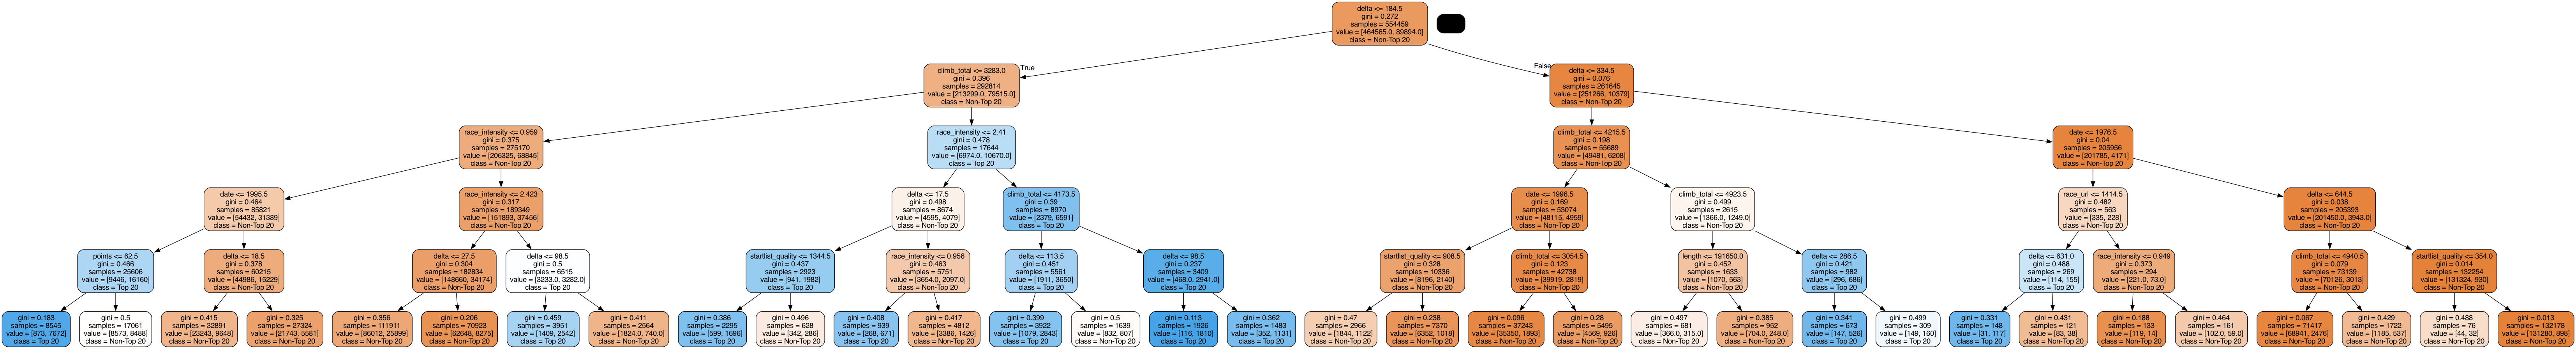

In [14]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=list(x_train.columns),  
                                class_names=['Non-Top 20', 'Top 20'],  
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())


Evaluation of the Decision Tree is done employing predictions, then we compute:

• Accuracy (for both train and test set; percentage of correct predictions)

• Precision (Percentage of correct predictions among all positive predictions)

• Recall (Percentage of true positives identified)

• F1 Score (Harmonic mean of precision and recall.)

In [15]:
#Prediction over training and test dataset employing Decision Tree
train_pred_dt = dt.predict(x_train)  
test_pred_dt = dt.predict(x_test)    

#Compute the performance of the model
print('Accuracy train set ', metrics.accuracy_score(y_train, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(y_test, test_pred_dt))
print('Precision train set ', metrics.precision_score(y_train, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(y_train, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(y_train, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(y_train, train_pred_dt))

Accuracy train set  0.8633821436751861
Accuracy test set  0.8763768852736824
Precision train set  0.8545822242950676
Recall train set  0.8633821436751861
F1 score train set  0.8285535766230132
Support train set  (array([0.86662216, 0.7923608 ]), array([0.98918773, 0.21322891]), array([0.92385757, 0.33603015]), array([464565,  89894]))


Confusion Matrix:
[[30152   314]
 [ 4063   877]]


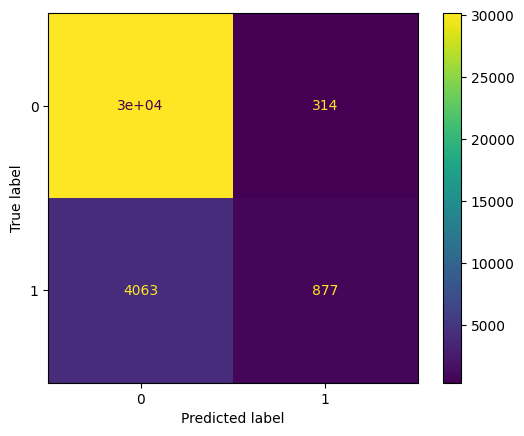

In [16]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_dt)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 30152 - Correct predictions for class 0.

- False Positives (FP): 314 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 4063 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 877 - Correct predictions for class 1.

In [17]:
# Scatter plot con etichette x ruotate e colormap migliorata
#plt.figure(figsize=(8, 6))  # Dimensione della figura

# Creazione dello scatter plot
#plt.scatter(test_set.iloc[:, 1], test_set.iloc[:, 3], c=test_label)

# Titoli e etichette
#plt.title("Scatter Plot of Test Set")
#plt.xlabel("Feature 1")
#plt.ylabel("Feature 2")
#plt.xticks(rotation=90)

# Mostrare la barra dei colori per l'etichettatura dei label
#plt.colorbar(label='Top 20 Labels')

#plt.show()

### Random Forest Model

The Random Forest works by combining the predictions of multiple decision trees (Ensemble learning) to improve the robustness and accuracy of the model.

Therefore, it employs Bagging (Bootstrap Aggregating), i.e. the use of random subsets of the data and features for each tree, reducing overfitting and Out-of-bag evaluation, an internal technique that evaluates performance without the need for a separate validation set.

Each tree is constructed using a random subset of the data (with repetition, bootstrap).
At each split, it considers a random subset of the features.

In [18]:
#Random Forest definition and training
rf = RandomForestClassifier(
    n_estimators=30, #Number of trees in the forest
    criterion='gini', #Measure to evaluate the purity of the split
    max_features=3, #Maximum number of features considered for each split
    max_depth=4, #Maximum depth of trees
    min_samples_split=2, #Minimum number of samples to split a node
    min_samples_leaf=8, #Minimum number of samples in a leaf
    bootstrap=True, #Use bootstrap to create random subsets
    random_state=42 #Ensures repeatability of results
)

#Model training
rf = rf.fit(x_train, y_train)

In [19]:
#Prediction over training and test employing Random Forest
train_pred_rf = rf.predict(x_train)  
test_pred_rf = rf.predict(x_test)    

#Compute the performance of the model
print('Accuracy:', metrics.accuracy_score(y_train, train_pred_rf))
print('Accuracy:', metrics.accuracy_score(y_test, test_pred_rf))
print('Precision:', metrics.precision_score(y_train, train_pred_rf, average='weighted', zero_division=0))
print('Recall:', metrics.recall_score(y_train, train_pred_rf, average='weighted', zero_division=0))
print('F1 Score:', metrics.f1_score(y_train, train_pred_rf, average='weighted', zero_division=0))
print('Support train set ', metrics.precision_recall_fscore_support(y_train, train_pred_rf))

Accuracy: 0.8498536411168364
Accuracy: 0.8604756256001808
Precision: 0.8570339025367746
Recall: 0.8498536411168364
F1 Score: 0.7935962246546414
Support train set  (array([0.84911859, 0.89793963]), array([0.99816603, 0.0833871 ]), array([0.91762939, 0.15260276]), array([464565,  89894]))


Confusion Matrix:
[[30466     0]
 [ 4940     0]]


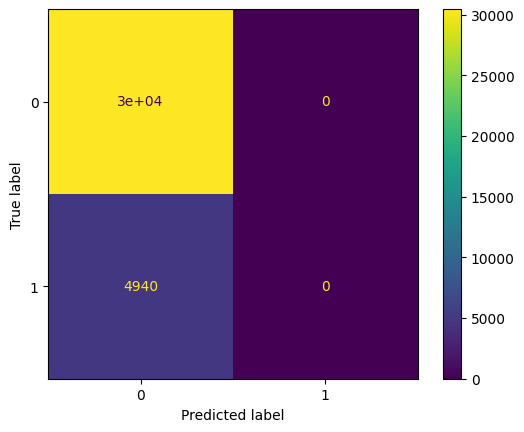

In [20]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_rf)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 30466 - Correct predictions for class 0.

- False Positives (FP): 0 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 4940 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 0 - Correct predictions for class 1.

### Gradient Boost Model

Gradient Boosting is an ensemble technique that combines several simple models, usually decision trees, to create a more powerful model. It is based on the idea of building sequential models, where each model corrects the errors of the previous one.
How does it work?

- Iterative construction:
At each iteration, a new model is added that reduces the residual (error) of the previous model.
This is done by optimising an objective function (e.g. log-loss by classification).

- Model weighing:
Each successive model is weighted so that the hard errors of the previous model matter more.

- Learning Rate:
Controls the amount of correction that each additional model brings. A low learning rate increases accuracy, but requires more iterations.

In [21]:
#from xgboost import XGBClassifier
#from xgboost import XGBClassifier
#Base model definition
#base_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
# hypothetical hyperparameter space
#hyperparameters = {
#    "n_estimators": [25, 100, 250], #Number of trees in the forest
 #   "max_depth": [2, 3], #Maximum depth of trees
  #  "learning_rate": [1, 0.1, 0.001], #Update weight per iteration
   # "subsample": [0.8, 1.0] #Percentage of data used in each tree
#}

#Random search for tuning hyperparameters
#search = RandomizedSearchCV(base_model, hyperparameters, cv=5, n_iter=10, random_state=42, scoring="f1_weighted")

#Training the model using the training set
#search.fit(train_set, train_label)

#Best model found
#clf = search.best_estimator_

#Training on the training set with the best model
#clf.fit(train_set, train_label)

In [22]:
#Prediction on test set
#test_pred_xgb = clf.predict(test_set)

#Prediction of the model
#print(classification_report(
#    test_label, 
#    test_pred_xgb, 
#    target_names=['Non Top 20', 'Top 20']
#))

### Final comparisons


In [23]:
#Dictionary containing trained models
models = {
    "Decision Tree": dt,          
    "Random Forest": rf,          
   # "Gradient Boosting": clf      
}

#Iteration on models to calculate and print metrics
for model_name, model in models.items():
    y_test_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_test_pred)
    conf = confusion_matrix(y_test, y_test_pred)
    report = classification_report(y_test, y_test_pred, target_names=["Non Top 20", "Top 20"], zero_division=0)
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Confusion Matrix:\n{conf}")
    print(f"Classification Report:\n{report}")



--- Decision Tree ---
Accuracy: 0.8764
Confusion Matrix:
[[30152   314]
 [ 4063   877]]
Classification Report:
              precision    recall  f1-score   support

  Non Top 20       0.88      0.99      0.93     30466
      Top 20       0.74      0.18      0.29      4940

    accuracy                           0.88     35406
   macro avg       0.81      0.58      0.61     35406
weighted avg       0.86      0.88      0.84     35406


--- Random Forest ---
Accuracy: 0.8605
Confusion Matrix:
[[30466     0]
 [ 4940     0]]
Classification Report:
              precision    recall  f1-score   support

  Non Top 20       0.86      1.00      0.93     30466
      Top 20       0.00      0.00      0.00      4940

    accuracy                           0.86     35406
   macro avg       0.43      0.50      0.46     35406
weighted avg       0.74      0.86      0.80     35406



 **Come leggere i risultati**

1. **`Accuracy`**:
   - Percentuale di predizioni corrette.
   - Utile per avere una visione generale delle performance, ma può essere ingannevole in caso di dataset sbilanciati.

2. **`Confusion Matrix`**:
   - Rappresenta visivamente i veri e falsi positivi/negativi.
   - Ogni cella indica:
     - **TN (0,0)**: Predizioni corrette per "Non Top 20".
     - **FP (0,1)**: Predizioni errate classificate come "Top 20".
     - **FN (1,0)**: Predizioni errate classificate come "Non Top 20".
     - **TP (1,1)**: Predizioni corrette per "Top 20".
   - Ti aiuta a identificare dove il modello sbaglia maggiormente.

3. **`Classification Report`**:
   - **Precision**:
     - Percentuale di predizioni corrette su tutte quelle fatte per una classe.
     - Formula: \( \text{Precision} = \frac{TP}{TP + FP} \).
     - Elevata precisione indica pochi falsi positivi.
   - **Recall (Sensibilità)**:
     - Percentuale di veri positivi catturati dal modello.
     - Formula: \( \text{Recall} = \frac{TP}{TP + FN} \).
     - Elevato recall indica pochi falsi negativi.
   - **F1-score**:
     - Media armonica di precision e recall, utile per bilanciare i due aspetti.
     - Formula: \( \text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} \).
   - **Support**:
     - Numero di campioni effettivi per ogni classe.

---

 **Esempio di interpretazione**

Supponiamo che l'output del modello Gradient Boosting sia:

```
--- Gradient Boosting ---
Accuracy: 0.85
Confusion Matrix:
[[180  20]
 [ 15  85]]
Classification Report:
              precision    recall  f1-score   support
Non Top 20       0.92      0.90      0.91       200
    Top 20       0.81      0.85      0.83       100
```

- **Accuracy**: 85%, cioè l'85% delle predizioni sono corrette.
- **Confusion Matrix**:
  - **180 TN**: "Non Top 20" predetto correttamente.
  - **20 FP**: Predetto "Top 20", ma in realtà "Non Top 20".
  - **15 FN**: Predetto "Non Top 20", ma in realtà "Top 20".
  - **85 TP**: "Top 20" predetto correttamente.
- **Classification Report**:
  - Per la classe "Non Top 20":
    - Precision: 92% (pochi FP).
    - Recall: 90% (pochi FN).
  - Per la classe "Top 20":
    - Precision: 81% (più FP).
    - Recall: 85% (meno FN).

In questo caso, puoi confrontare le metriche tra i modelli per scegliere quello con il miglior bilanciamento di precision e recall per il tuo scopo.

## ! Support Vector Machines (SVM) (10 min)

In [ ]:
#Creating and configuring the SVM model
svm = SVC(
    kernel="sigmoid",
    C=0.5,
    gamma="scale", 
    probability=True #Enable probability prediction
)

#Model training
svm.fit(x_train, y_train)  



In [ ]:
#Predict probabilities on the test set
test_pred_proba_svm = svm.predict_proba(x_test)  
test_pred_proba_svm

In [ ]:
test_pred_svm = svm.predict(x_test)
test_pred_svm

In [ ]:
#Metrix
acc = accuracy_score(y_test, test_pred_svm)
conf_matrix = confusion_matrix(y_test, test_pred_svm)
report = classification_report(y_test, test_pred_svm, target_names=["Non Top 20", "Top 20"], zero_division=0)
print("\n--- SVM Model ---")
print(f"Accuracy: {acc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{report}")

In [ ]:
#Confusion matrix
#conf_matrix = confusion_matrix(test_label, test_pred_svm)
print("\nConfusion Matrix:\n", conf_matrix)

## Naïve Bayes

In [21]:
# Creazione e addestramento del modello Naïve Bayes
gnb = GaussianNB()
gnb.fit(x_train, y_train)  # Assicurati di passare solo features e target

# Predizione sul test set
train_pred_gnb = gnb.predict(x_train)
test_pred_gnb = gnb.predict(x_test)


print('Accuracy train set ', metrics.accuracy_score(y_train, train_pred_gnb))
print('Accuracy test set ', metrics.accuracy_score(y_test, test_pred_dt))
print('Precision train set ', metrics.precision_score(y_train, train_pred_gnb, average='weighted'))
print('Recall train set ', metrics.recall_score(y_train, train_pred_gnb, average='weighted'))
print('F1 score train set ', metrics.f1_score(y_train, train_pred_gnb, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(y_train, train_pred_gnb))


Confusion Matrix:
[[26782  3684]
 [ 3795  1145]]


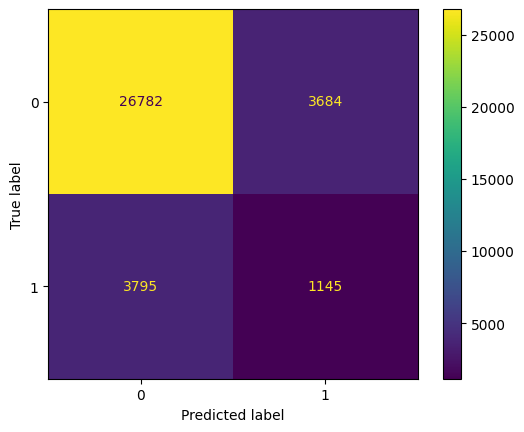

In [34]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_gnb)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 26782 - Correct predictions for class 0.

- False Positives (FP): 3684 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 3795 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 1145 - Correct predictions for class 1.

## K-Nearest Neighbors (KNN)

n_neighbors=3: Considera i 3 vicini più prossimi per classificare un nuovo campione.
algorithm='ball_tree': Algoritmo che ottimizza la ricerca dei vicini più prossimi.
metric='minkowski': Misura la distanza Euclidea tra campioni.

In [24]:
#Definition of KNN model with 3 neighbours and ‘ball_tree’ algorithm
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric='minkowski')

#Train KNN on the training data
knn.fit(x_train, y_train) 

#Prediction
train_pred_knn = knn.predict(x_train)  # Predictions on the training set
test_pred_knn = knn.predict(x_test)    # Predictions on the test set

# Calculate metrics and print results
print('Accuracy train set ', metrics.accuracy_score(y_train, train_pred_knn))
print('Accuracy test set ', metrics.accuracy_score(y_test, test_pred_knn))
print('Precision train set ', metrics.precision_score(y_train, train_pred_knn, average='weighted'))
print('Recall train set ', metrics.recall_score(y_train, train_pred_knn, average='weighted'))
print('F1 score train set ', metrics.f1_score(y_train, train_pred_knn, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(y_train, train_pred_knn))



 --- K-Nearest Neighbors Classifier ---
Accuracy: 0.7930
Confusion Matrix:
[[26211  4255]
 [ 3075  1865]]
Classification Report:
              precision    recall  f1-score   support

  Non Top 20       0.90      0.86      0.88     30466
      Top 20       0.30      0.38      0.34      4940

    accuracy                           0.79     35406
   macro avg       0.60      0.62      0.61     35406
weighted avg       0.81      0.79      0.80     35406



Confusion Matrix:
[[26211  4255]
 [ 3075  1865]]


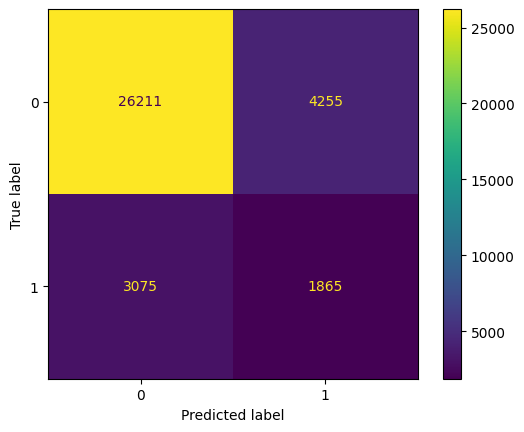

In [36]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_knn)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 26211 - Correct predictions for class 0.

- False Positives (FP): 4255 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 3075 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 1865 - Correct predictions for class 1.

## Neural Network

In [27]:
import numpy as np
import tensorflow as tf

# Convert labels to NumPy arrays
y_train = np.asarray(y_train).astype('float32').reshape((-1, 1))  # Convert training labels to NumPy arrays
y_test = np.asarray(y_test).astype('float32').reshape((-1, 1))    # Convert test labels to NumPy arrays

# Define the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),  # Input layer
    tf.keras.layers.Dropout(0.2),  # Dropout to prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer
    tf.keras.layers.Dropout(0.2),  # Dropout to improve generalization
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adamax',                       # Adam optimizer
              loss='mean_squared_error',             # Binary cross-entropy for binary classification
              metrics=['accuracy'])                   # Track accuracy during training and evaluation

# Train the model
history = model.fit(
    x_train, y_train,                 # Training data
    epochs=80,                        # Number of training epochs
    batch_size=256,                    # Batch size
    validation_split=0.2          # Verbose output for training progress
)



/Users/papple/Desktop/Unipi/Esami/DATAMINING/dm_project24_group_4/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8370 - loss: 0.1630 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 2/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8399 - loss: 0.1601 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 3/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8402 - loss: 0.1598 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 4/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8403 - loss: 0.1597 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 5/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8403 - loss: 0.1597 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 6/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8403 - loss: 0.1597 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 7/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8397 - loss: 0.1603 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 8/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8407 - loss: 0.1593 - 

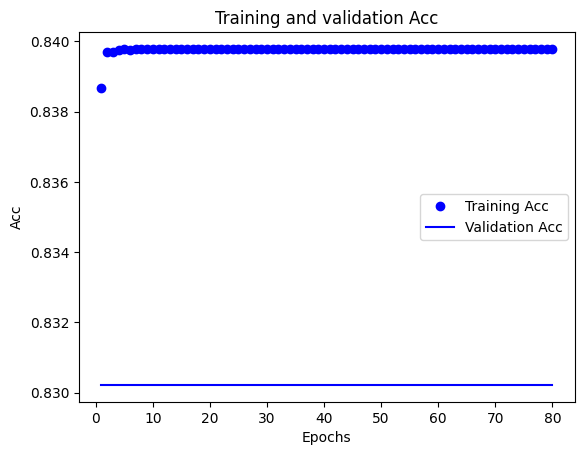

In [28]:
# Plot the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [29]:
# Make predictions
test_pred_proba = model.predict(x_test)
test_pred = (test_pred_proba > 0.5).astype('int32')

# Make predictions on training set
train_pred_proba = model.predict(x_train)  # Predict probabilities for training set
train_pred = (train_pred_proba > 0.5).astype('int32') 

print('Accuracy train set ', metrics.accuracy_score(y_train, train_pred_proba))
print('Accuracy test set ', metrics.accuracy_score(y_test, test_pred_proba))
print('Precision train set ', metrics.precision_score(y_train, train_pred_proba, average='weighted'))
print('Recall train set ', metrics.recall_score(y_train, train_pred_proba, average='weighted'))
print('F1 score train set ', metrics.f1_score(y_train, train_pred_proba, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(y_train, train_pred_proba))


1107/1107 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
17327/17327 ━━━━━━━━━━━━━━━━━━━━ 4s 229us/step
Accuracy train set  0.8378707893640468
Accuracy test set  0.8604756256001808
Precision train set  0.7020274596695308
Recall train set  0.8378707893640468
F1 score train set  0.7639573616733432
Support train set  (array([0.83787079, 0.        ]), array([1., 0.]), array([0.91178422, 0.        ]), array([464565,  89894]))


/Users/papple/Desktop/Unipi/Esami/DATAMINING/dm_project24_group_4/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/papple/Desktop/Unipi/Esami/DATAMINING/dm_project24_group_4/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[30466     0]
 [ 4940     0]]


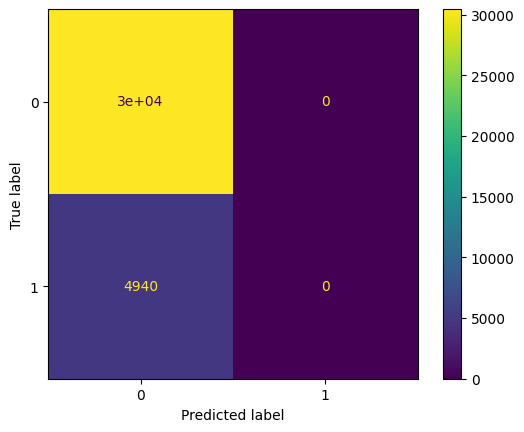

In [ ]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_proba)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 30466 - Correct predictions for class 0.

- False Positives (FP): 0 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 4940 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 0 - Correct predictions for class 1.

## Rule based (16 min)

In [ ]:
# Definizione del modello RIPPER
ripper = lw.RIPPER()

# Definizione della griglia dei parametri da testare
param_grid = {
    "prune_size": [0.5, 0.6],  
    "k": [1, 3]
}

# Impostare GridSearchCV con validazione incrociata a 5 fold
grid_search = GridSearchCV(estimator=ripper, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=3, 
                           n_jobs=-1)

# Adatta la ricerca a griglia ai dati di training
grid_search.fit(x_train, y_train)

# Visualizzare i migliori parametri trovati
print('Best parameters setting:', grid_search.best_params_)


In [ ]:
# Predici i valori sul test set
best_ripper = grid_search.best_estimator_  # Modello con i migliori parametri
y_test_pred = best_ripper.predict(x_test)

# Valutazione delle prestazioni del modello
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

print("\nAccuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter Plot delle prime due caratteristiche del test set
plt.scatter(
    x_test.iloc[:, 0].values,  # Prima caratteristica
    x_test.iloc[:, 1].values,  # Seconda caratteristica
    c=test_pred,               # Predizioni del modello
    cmap='RdBu',               # Mappa colori per le classi
    s=25                       # Dimensione dei punti
)

# Titolo e Etichette
plt.title('Rule-Based Predictions (Test Set)')
plt.xlabel('Feature 1')  # Etichetta asse x
plt.ylabel('Feature 2')  # Etichetta asse y
plt.colorbar(label='Predicted Class')  # Barra dei colori per le classi
plt.show()


## Comparison between all models

- **ROC curve**: Displays the relationship between the True Positive Rate and the False Positive Rate. A curve closer to the upper left corner indicates better performance.

- **AUC (Area Under Curve)**: A higher AUC value indicates a better predictive ability of the model. The maximum value is 1 (perfect classifier), while 0.5 indicates a random model.

1107/1107 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


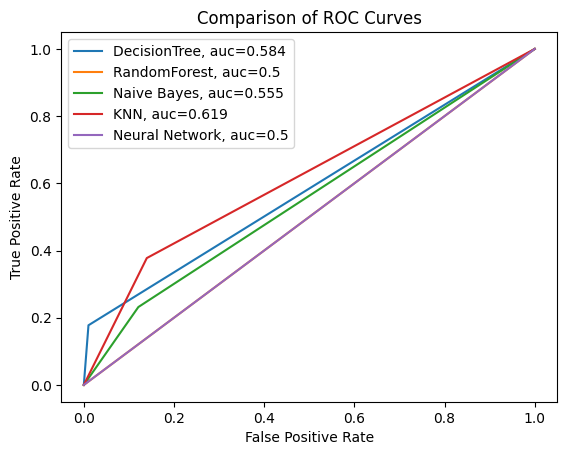

In [32]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure(0).clf()  # Clear the current figure

# Decision Tree
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_dt)
auc = metrics.roc_auc_score(y_test, test_pred_dt)
plt.plot(fpr, tpr, label="DecisionTree, auc=" + str(round(auc, 3)))

# Random Forest
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_rf)
auc = metrics.roc_auc_score(y_test, test_pred_rf)
plt.plot(fpr, tpr, label="RandomForest, auc=" + str(round(auc, 3)))

# XGBoost
#fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_xgb)
#auc = metrics.roc_auc_score(y_test, test_pred_xgb)
#plt.plot(fpr, tpr, label="XGBoost Classifier, auc=" + str(round(auc, 3)))


# Naive Bayes
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_gnb)
auc = metrics.roc_auc_score(y_test, test_pred_gnb)
plt.plot(fpr, tpr, label="Naive Bayes, auc=" + str(round(auc, 3)))


# K-Nearest Neighbor
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_knn)
auc = metrics.roc_auc_score(y_test, test_pred_knn)
plt.plot(fpr, tpr, label="KNN, auc=" + str(round(auc, 3)))

# Support Vector Machine
#fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_svm)
#auc = metrics.roc_auc_score(y_test, test_pred_svm)
#plt.plot(fpr, tpr, label="SVM, auc=" + str(round(auc, 3)))

# Neural Network
test_pred_nn = model.predict(x_test).ravel()  # Predict probabilities for Neural Network
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_nn)
auc = metrics.roc_auc_score(y_test, test_pred_nn)
plt.plot(fpr, tpr, label="Neural Network, auc=" + str(round(auc, 3)))

# Rule-Based (if RIPPER is defined)
#if "ripper" in globals():  # Check if RIPPER model exists
##    test_pred_rb = ripper.predict_proba(x_test)[:, 1]  # Predict probabilities with RIPPER
#    fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_rb)
#    auc = metrics.roc_auc_score(y_test, test_pred_rb)
#    plt.plot(fpr, tpr, label="Rule-Based, auc=" + str(round(auc, 3)))

# Layout
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend(loc=0)
plt.show()
